Trabalho de regressão multivariável de um dataset de diamantes  
Disciplina: Introdução ao Aprendizado de Máquina (EEL891)  
Professor: Heraldo Luís Silveira de Almeida  
Aluno: Pedro Felipe Leal Pedrosa (DRE: 113210411)

# Importando as bibliotecas

In [1]:
# Ignorando alguns tipos de erro
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas de manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para pré-processamentos, modelos e métricas
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, \
GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
# É necessário instalar no anaconda com o comando "pip install xgboost"
from xgboost import XGBRegressor
# É necessário instalar no anaconda com o comando "pip install catboost"
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import r2_score, make_scorer

# Análise e manipulação dos dados

## Leitura

Realizando uma breve visualização prévia dos conjuntos de dados fornecidos (em excel), temos um dataset "train.csv" que possui todos os preços (target) e será usado parcialmente para treinar e avaliar o modelo. O dataset "test.csv" não possui os preços, então só será usado ao final, onde o dataset "train.csv" será integralmente utilizado para predizer os preços do dataset "test.csv" e as predições serão enviadas para o kaggle para cálculo da pontuação.

Dado isso, as análises serão feitas no dataset "train.csv" e, quando necessário, algumas manipulações serão replicadas ao "test.csv", para que ele fique preparado para receber o modelo.

In [2]:
ds = pd.read_csv('data/train.csv')
x_kaggle = pd.read_csv('data/test.csv')

## Análise e manipulação inicial

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33940 entries, 0 to 33939
Data columns (total 11 columns):
id         33940 non-null int64
carat      33940 non-null float64
cut        33940 non-null object
color      33940 non-null object
clarity    33940 non-null object
x          33940 non-null float64
y          33940 non-null float64
z          33940 non-null float64
depth      33940 non-null float64
table      33940 non-null float64
price      33940 non-null int64
dtypes: float64(6), int64(2), object(3)
memory usage: 2.8+ MB


In [4]:
ds.head()

id  carat        cut color clarity     x     y     z  depth  table  \
0  20000   0.35  Very Good     G    VVS2  4.44  4.48  2.80   62.8   58.0   
1  20001   0.70      Ideal     F     SI1  5.66  5.69  3.55   62.6   56.0   
2  20002   0.32      Ideal     F    VVS1  4.42  4.38  2.70   61.4   56.0   
3  20003   0.30      Ideal     H    VVS2  4.32  4.35  2.67   61.7   54.2   
4  20004   0.33    Premium     I    VVS2  4.41  4.47  2.76   62.2   59.0   

   price  
0    798  
1   2089  
2    990  
3    631  
4    579

In [5]:
# Setando o index = id
ds = ds.set_index('id')
x_kaggle = x_kaggle.set_index('id')

In [6]:
ds.describe()

carat             x             y             z         depth  \
count  33940.000000  33940.000000  33940.000000  33940.000000  33940.000000   
mean       0.796249      5.727926      5.730563      3.535916     61.746491   
std        0.472866      1.119282      1.120279      0.693763      1.425570   
min        0.200000      0.000000      0.000000      0.000000     43.000000   
25%        0.400000      4.710000      4.720000      2.910000     61.000000   
50%        0.700000      5.700000      5.710000      3.520000     61.800000   
75%        1.040000      6.540000      6.530000      4.030000     62.500000   
max        5.010000     10.740000     31.800000      6.980000     79.000000   

              table         price  
count  33940.000000  33940.000000  
mean      57.467664   3920.022864  
std        2.237116   3980.229999  
min       44.000000    326.000000  
25%       56.000000    952.000000  
50%       57.000000   2395.000000  
75%       59.000000   5294.000000  
max       95.000000  18823.000000

Existem valores mínimos de x, y e z zerados, sendo que os valores de depth e table calculados baseados nesses valores não apresentam valores zerados. Inicialmente, pensei em excluir as linhas onde x, y ou z eram zero, mas com o teste dos modelos mais a frente, vi que na maioria dos casos isso piorava os modelos ligeiramente (quase imperceptível). Logo, resolvi manter essas linhas.

In [7]:
# Número de linhas com atributos x, y ou z zerados
print((ds.x == 0).sum())
print((ds.y == 0).sum())
print((ds.z == 0).sum())

3
3
11


In [8]:
ds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
price      0
dtype: int64

Não existe nenhum valor null, logo não é preciso tratar.

In [9]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33940 entries, 20000 to 53939
Data columns (total 10 columns):
carat      33940 non-null float64
cut        33940 non-null object
color      33940 non-null object
clarity    33940 non-null object
x          33940 non-null float64
y          33940 non-null float64
z          33940 non-null float64
depth      33940 non-null float64
table      33940 non-null float64
price      33940 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.8+ MB


## Análise dos atributos numéricos

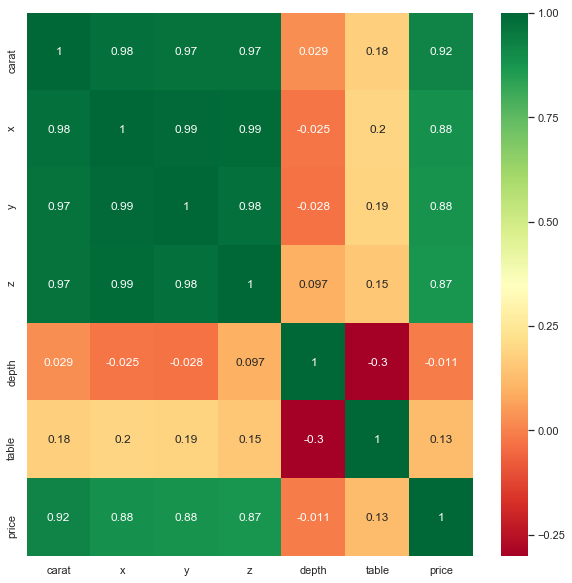

In [10]:
# Matriz de correlação entre atributos
sns.set(palette = "Spectral")
plt.figure(figsize = (10, 10))
sns.heatmap(ds.corr(), annot = True, cmap = 'RdYlGn')
plt.show()

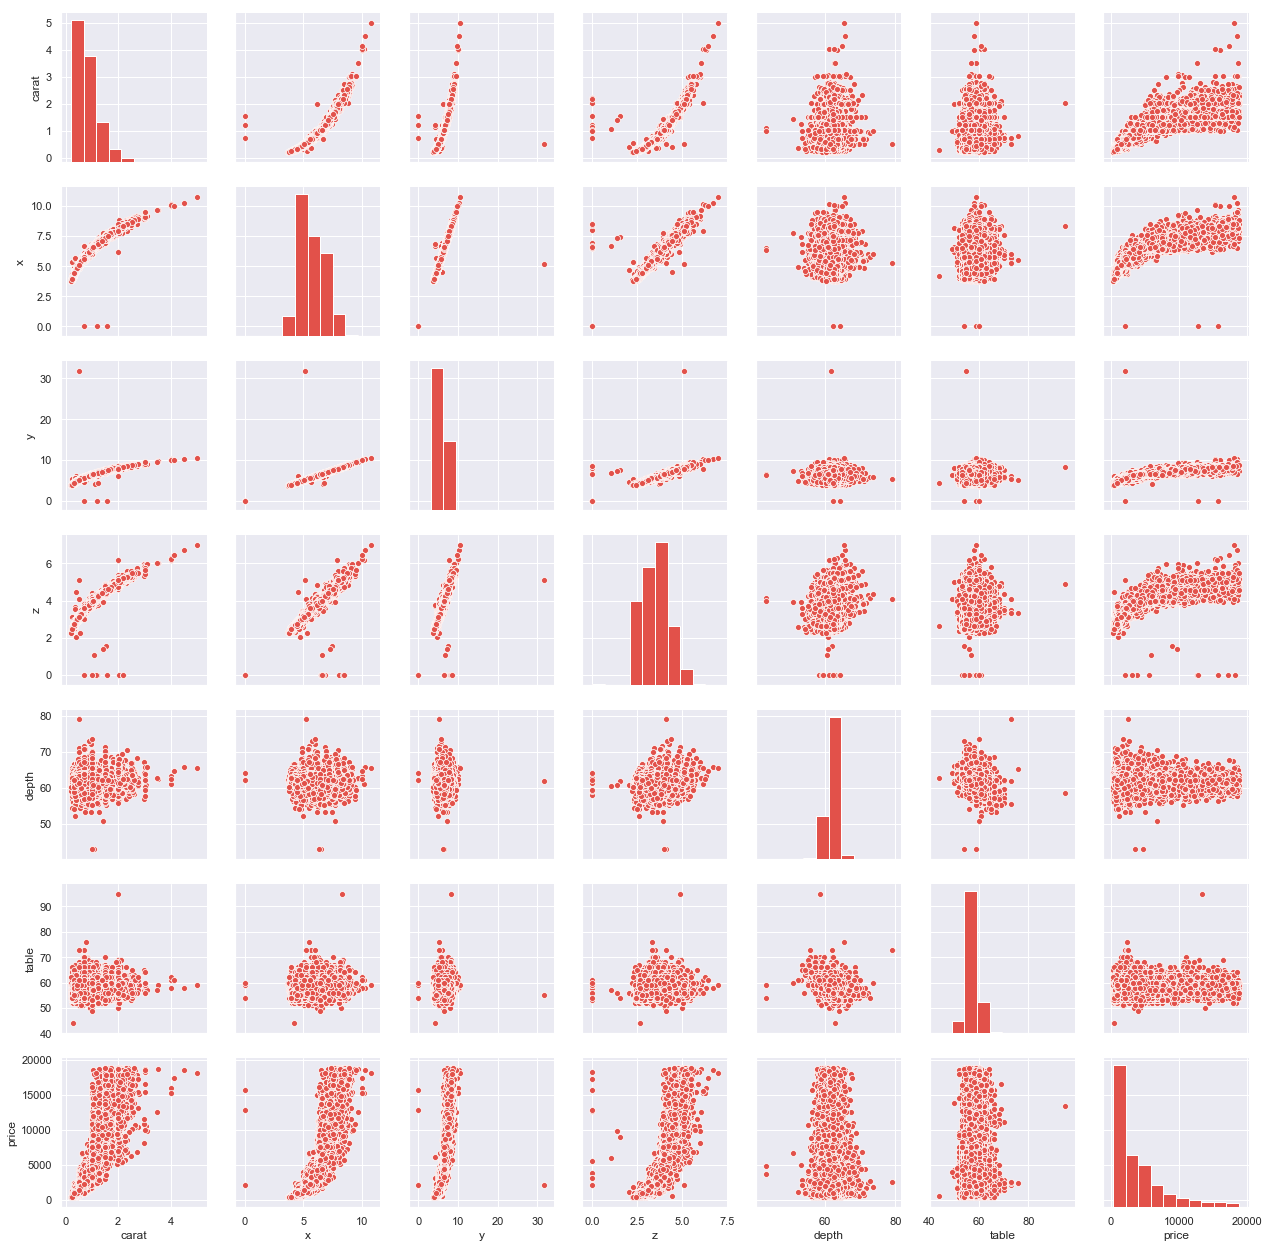

In [11]:
# Gráficos de dispersão
sns.pairplot(ds)
plt.show()

Observações:

- Os atributos x, y, z e carat possuem grande correlação com preço, mas também possuem grande correlação entre si
- Os atributos depth e table são baseados em x, y e z, mas não possuem correlação direta com o preço

## Análise dos atributos categóricos

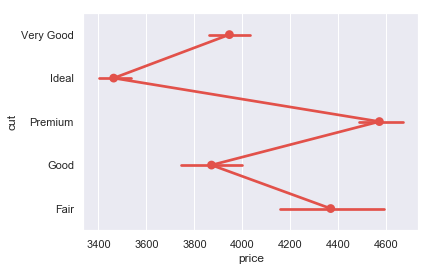

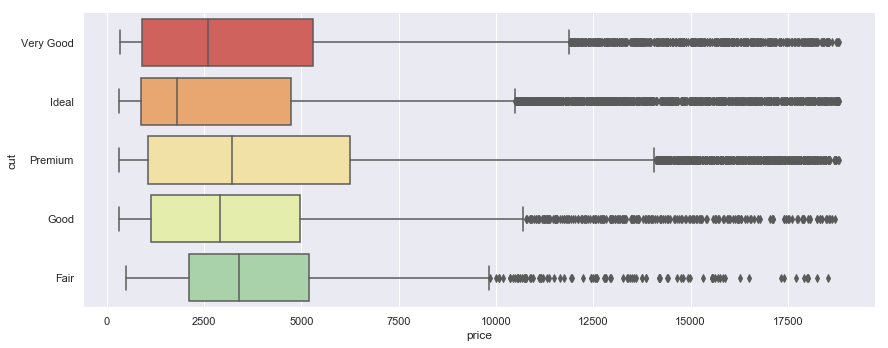

In [12]:
sns.pointplot(x = 'price', y = 'cut', data = ds, orient = 'h')
sns.catplot(x = 'price', y = 'cut', data = ds, kind = 'box', orient = 'h', \
            aspect = 2.5)
plt.show()

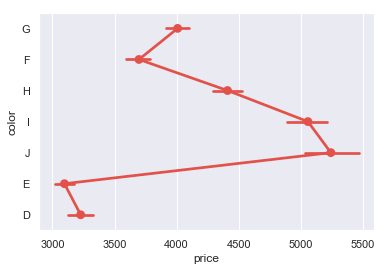

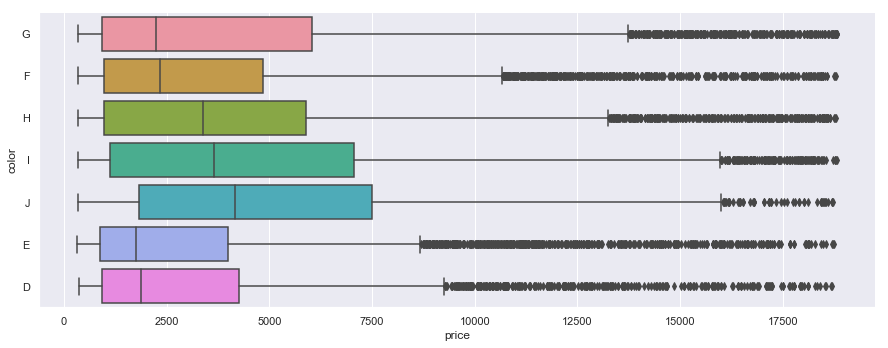

In [13]:
sns.pointplot(x = 'price', y = 'color', data = ds, orient = 'h')
sns.catplot(x = 'price', y = 'color', data = ds, kind = 'box', orient = 'h', \
            aspect = 2.5)
plt.show()

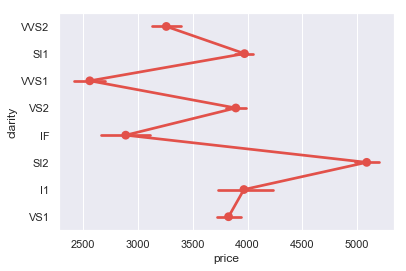

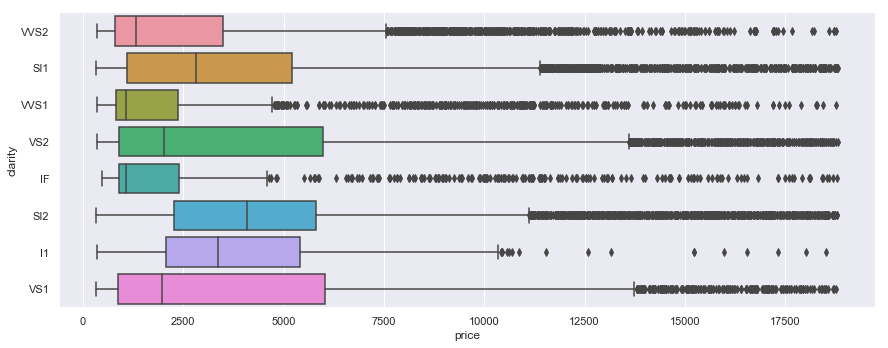

In [14]:
sns.pointplot(x = 'price', y = 'clarity', data = ds, orient = 'h')
sns.catplot(x = 'price', y = 'clarity', data = ds, kind = 'box', orient = 'h', \
            aspect = 2.5)
plt.show()

Observações:
    
- Comparado com carat, x, y e z, os atributos cut, color e clarity não parecem ter uma correlação tão alta com preço
- A mediana e média são relativamente baixas, enquanto que a variação do preço é extremamente alta para qualquer categoria, o que mostra que a influência dessas categorias sobre o preço não é tão alta

Conclusão: Apesar das observações, isso não quer dizer que esses atributos não sejam importantes. Dado um preço genérico de um diamante, estimado puramente pelas dimensões x, y e z, essas categorias podem ser cruciais para fazer o "fine-tuning" do preço final e isso pode contribuir significativamente para métricas como o RMSPE que leva muito em consideração os erros de casos individuais.

## Tratamento para atributos categóricos

Para alimentar os modelos do scikit-learn, precisa-se primeiramente transformar os atributos categóricos em atributos numéricos. Existem duas formas de se fazer isso:

1. Integer Encoding: trata-se de manter o atributo, mas atribuir um inteiro numérico para cada categoria
2. One Hot Encoding: trata-se de elimitar o atributo e criar um atributo booleano para cada categoria
        
Com isso em mente, dois datasets foram criados, um para cada método, sendo que no método de integer encoding, foram atribuídos números inteiros aleatórios para cada categoria. Nessa implementação, o método de one hot encoding obteve resultados muito melhores em modelos lineares e resultados parecidos em modelos de árvore de decisão. Isso se deve pelo fato de termos um grande problema com integer encoding, onde grande parte dos regressores acaba interpretando esse número como um peso, que pode tanto ajudar quanto prejudicar o modelo. No caso de números aleatórios, existe grande chance disso prejudicar o modelo.

Desta forma, reapliquei o integer encoding atribuindo um número inteiro próximo a média de cada categoria. E após isso, o método integer encoding foi vencedor em relação ao de one hot encoding.

Assim, aplica-se o integer encoding daqui em diante.

In [15]:
cut_means = ds.groupby('cut')['price'].mean()
color_means = ds.groupby('color')['price'].mean()
clarity_means = ds.groupby('clarity')['price'].mean()

print(cut_means.reset_index().sort_values(['price']).set_index(['cut']))
print(color_means.reset_index().sort_values(['price']).set_index(['color']))
print(clarity_means.reset_index().sort_values(['price']).set_index(['clarity']))

                 price
cut                   
Ideal      3463.630512
Good       3871.440902
Very Good  3946.085684
Fair       4368.407446
Premium    4571.406826
             price
color             
E      3096.514071
D      3227.263853
F      3696.962895
G      4008.365961
H      4410.510329
I      5058.310035
J      5243.350315
               price
clarity             
VVS1     2559.002558
IF       2887.105778
VVS2     3257.689121
VS1      3826.168559
VS2      3892.566332
I1       3966.451064
SI1      3971.791884
SI2      5087.433554


In [16]:
# Integer encoding
cut_obj = {'Ideal': 3463, 
           'Good': 3871, 
           'Very Good': 3946, 
           'Fair': 4368, 
           'Premium': 4571
}

color_obj = {'E': 3096, 
             'D': 3227, 
             'F': 3696, 
             'G': 4008, 
             'H': 4410, 
             'I': 5058, 
             'J': 5243
}

clarity_obj = {'VVS1': 2559, 
               'IF': 2887, 
               'VVS2': 3257, 
               'VS1': 3826, 
               'VS2': 3892,
               'I1': 3966, 
               'SI1': 3971, 
               'SI2': 5087
}

ds['cut'] = ds['cut'].replace(cut_obj, inplace = False)
ds['color'] = ds['color'].replace(color_obj, inplace = False)
ds['clarity'] = ds['clarity'].replace(clarity_obj, inplace = False)

# Reproduzindo para o x_kaggle que será usado ao final para envio das predições
x_kaggle['cut'] = x_kaggle['cut'].replace(cut_obj, inplace = False)
x_kaggle['color'] = x_kaggle['color'].replace(color_obj, inplace = False)
x_kaggle['clarity'] = x_kaggle['clarity'].replace(clarity_obj, inplace = False)

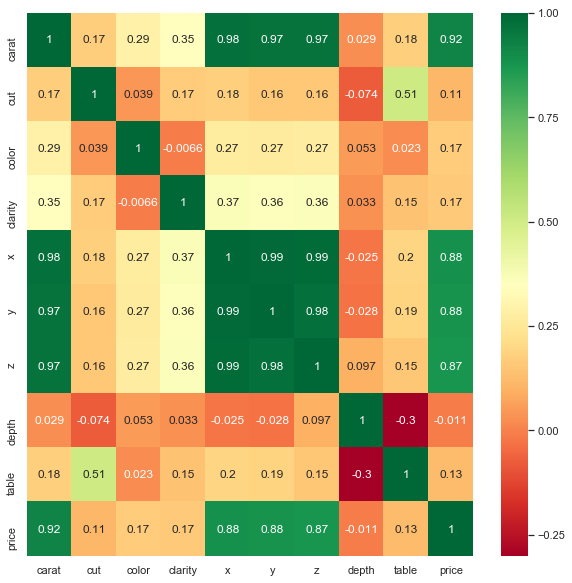

In [17]:
# Matriz de correlação entre atributos após tratamento
plt.figure(figsize = (10, 10))
sns.heatmap(ds.corr(), annot = True, cmap = 'RdYlGn')
plt.show()

<p>Observação: relativamente alta correlação entre cut e table.</p>

## Tentativa de engenharia e seleção de atributos

Dado que existe uma correlação alta entre x, y e z, tentou-se criar um novo atributo chamado volume, sendo esse, o produto entre x, y e z. Na tentativa de remover o x, y e z a favor do novo atributo volume, houve uma queda perceptível da performance do melhor modelo escolhido ao final desse relatório, sem grandes diminuições em processamento. Com isso, optou-se por usar x, y e z.

Também tentou-se fazer um backward selection dos atributos, mas qualquer remoção de atributo na primeira iteração piorava o modelo. A remoção que menos impactou a performance do modelo foi a do atributo cut (pode ser ocasionado pela alta correlação achada entre table e cut).
    
Como opta-se pelo integer encoding, já temos um número pequenos de atributos, então optou-se por continuar com todos os atributos, já que o tempo de processamento já é relativamente baixo.

# Treinamento e teste inicial de modelos

Primeiramente, divide-se o dataset "train.csv" da seguinte forma: 70% para treinamento e 30% para teste. Após isso, testa-se diversos modelos com mínima interferência nos hiperparâmetros.

In [18]:
# Criando as arrays de treino e test
x = ds.copy().drop(['price'], axis=1)
y = ds.copy()['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, \
                                                    random_state = 7)

In [19]:
# Criando arrays para comparação entre modelos
rmspe_arr = []
model_arr = ['Linear', 'Lasso', 'Ridge', 'KNeighbors', 'AdaBoost', 
             'GradientBoosting', 'XGBoost', 'CatBoost', 'Bagging', 
             'Random Forest', 'Extra Trees'
]

In [20]:
# Criando função que calcula o RMSPE, que será usada para avaliar os modelos
def rmspe_score(y_test, y_pred):
    
    rmspe = np.sqrt(np.mean(np.square(((y_test - y_pred) / y_test)), axis = 0))

    return rmspe

In [21]:
# Função de regressão genérica que coloca o rmspe em um array
def reg(x_train, x_test, y_train, y_test, func):

    func.fit(x_train , y_train)
    y_pred = func.predict(x_test)
    rmspe = rmspe_score(y_test, y_pred)
    rmspe_arr.append(rmspe)

    print('RMSPE: %0.6f ' % rmspe)

In [22]:
lr = LinearRegression()
reg(x_train, x_test, y_train, y_test, lr)

RMSPE: 0.693831 


In [23]:
lar = Lasso(normalize = True)
reg(x_train, x_test, y_train, y_test, lar)

RMSPE: 0.509718 


In [24]:
rr = Ridge(normalize = True)
reg(x_train, x_test, y_train, y_test, rr)

RMSPE: 0.491770 


In [25]:
knr = KNeighborsRegressor()
reg(x_train, x_test, y_train, y_test, knr)

RMSPE: 0.407357 


In [26]:
abr = AdaBoostRegressor(random_state = 77)
reg(x_train, x_test, y_train, y_test, abr)

RMSPE: 0.549954 


In [27]:
gbr = GradientBoostingRegressor(random_state = 77)
reg(x_train, x_test, y_train, y_test, gbr)

RMSPE: 0.162906 


In [28]:
xgbr = XGBRegressor(seed = 77)
reg(x_train, x_test, y_train, y_test, xgbr)

[00:52:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSPE: 0.160137 


In [29]:
cbr = CatBoostRegressor(random_state = 77, logging_level = 'Silent')
reg(x_train, x_test, y_train, y_test, cbr)

RMSPE: 0.132598 


In [30]:
bg = BaggingRegressor(n_estimators = 100, random_state = 77)
reg(x_train, x_test, y_train, y_test, bg)

RMSPE: 0.100071 


In [31]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 77)
reg(x_train, x_test, y_train, y_test, rfr)

RMSPE: 0.100207 


In [32]:
etr = ExtraTreesRegressor(n_estimators = 100, random_state = 77)
reg(x_train, x_test, y_train, y_test, etr)

RMSPE: 0.103045 


In [33]:
compare = pd.DataFrame({'Model' : model_arr , 'RMSPE' : rmspe_arr})
compare.sort_values(by = 'RMSPE')

Model     RMSPE
8            Bagging  0.100071
9      Random Forest  0.100207
10       Extra Trees  0.103045
7           CatBoost  0.132598
6            XGBoost  0.160137
5   GradientBoosting  0.162906
3         KNeighbors  0.407357
2              Ridge  0.491770
1              Lasso  0.509718
4           AdaBoost  0.549954
0             Linear  0.693831

Conclusão: Como esperado, já que são modelos considerados "plug and play", ou seja, não precisam de muitos ajustes para que a performance seja razoavelmente boa, os regressores Bagging, Random Forest e Extra Trees foram os melhores modelos com mínima interferência de hiperparâmetros.

# Maximizando hiperparâmetros

Sabe-se que os modelos GradientBoosting, XGBoost e CatBoost são altamente dependentes de ajuste de hiperparâmetros. Como o ajuste de hiperparâmetos por validação cruzada requer grande quantidade de processamento, e portanto, muito tempo, descarta-se o CatBoost.
    
Além desses, iniciei pelo ajuste do Random Forest que é o modelo com maior oportunidade de melhora dentre os três melhores que foram encontrados até agora.

## Random Forest

Para o Random Forest, realiza-se uma procura randômica de melhores hiperparâmetros com 100 iterações e 3 validações cruzadas para minimização do erro RMSPE. Depois, usa-se o conhecimento da procura randômica para testarmos todas as iterações em uma grade de procura menor.

In [34]:
# Resetando arrays de comparação entre modelos
rmspe_arr = []
model_arr = ['1st RF', '2nd RF', '1st GBR', '1st XGBR', '2nd GBR', '2nd XGBR']

In [35]:
# Setando grid para fazer uma random search
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_features = [6, 7, 8]
max_depth = [int(x) for x in np.linspace(30, 100, 8)]
min_samples_split = [2, 5, 8 ,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
random_state = [77]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': random_state
}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [6, 7, 8], 'max_depth': [30, 40, 50, 60, 70, 80, 90, 100], 'min_samples_split': [2, 5, 8, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True], 'random_state': [77]}


In [9]:
# Random search do RF com 100 iterações
rfr = RandomForestRegressor()
rfr_random = RandomizedSearchCV(estimator = rfr, 
                                param_distributions = random_grid, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose = 2, 
                                random_state = 77, 
                                n_jobs = -1,
                                scoring = make_scorer(rmspe_score, \
                                                      greater_is_better = False)
)
rfr_random.fit(x, y)
rfr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.2min finished


{'random_state': 77,
 'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 8,
 'max_depth': 90,
 'bootstrap': True}

In [36]:
# RF com parâmetros da primeira rodada
rfr = RandomForestRegressor(n_estimators = 2000,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 8,
                            max_depth = 90,
                            bootstrap = True,
                            random_state = 77,
                            n_jobs = -1
)
reg(x_train, x_test, y_train, y_test, rfr)

RMSPE: 0.097679 


In [9]:
# Grid search do RF baseado nos resultados do random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 70],
    'max_features': [7, 8],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [600, 1600, 1800, 2000],
    'random_state': [77]
}

rfr = RandomForestRegressor()
rfr_grid = GridSearchCV(estimator = rfr, 
                        param_grid = param_grid, 
                        cv = 3,
                        verbose = 2,
                        n_jobs = -1,
                        scoring = make_scorer(rmspe_score, greater_is_better = False)
)
rfr_grid.fit(x, y)
rfr_grid.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 52.1min finished


{'bootstrap': True,
 'max_depth': 50,
 'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 2000,
 'random_state': 77}

In [37]:
# RF com parâmetros da segunda rodada
rfr = RandomForestRegressor(n_estimators = 2000,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 8,
                            max_depth = 50,
                            bootstrap = True,
                            random_state = 77,
                            n_jobs = -1
)
reg(x_train, x_test, y_train, y_test, rfr)

RMSPE: 0.097679 


## GradientBoosting e XGBoost

Para o GradientBoosting, também houve um passo de procura randômica com 100 iterações, mas ela foi feita em um notebook separado, então só será demostrado as procuras de grade. No caso do XGBoost, foi-se direto para a procura de grade, porque é um método extremamente parecido com o GradientBoosting, então os parâmetros iniciais não variariam tanto.

Como esses dois foram os modelos que reproduziram os melhores resultados, foram feitas duas rodads de procura de grade com validação cruzada.

In [12]:
# Primeira rodada de grid search do GBR
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [10],
    'max_features': [6],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [200, 400, 600, 800, 1000, 2000, 3000, 4000],
    'random_state': [77]
}

gbr = GradientBoostingRegressor()
gbr_grid = GridSearchCV(estimator = gbr, 
                        param_grid = param_grid, 
                        cv = 3,
                        verbose = 2,
                        n_jobs = -1,
                        scoring = make_scorer(rmspe_score, greater_is_better = False)
)
gbr_grid.fit(x, y)
gbr_grid.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 38.2min finished


{'learning_rate': 0.01,
 'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 3000,
 'random_state': 77}

In [38]:
# GBR com parâmetros da primeira rodada
gbr = GradientBoostingRegressor(n_estimators = 3000,
                                learning_rate = 0.01,
                                min_samples_leaf = 2, 
                                min_samples_split = 5, 
                                max_features = 6,
                                max_depth = 10, 
                                random_state = 77
)
reg(x_train, x_test, y_train, y_test, gbr)

RMSPE: 0.089617 


In [11]:
# Primeira rodada de grid search do XGBR
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_depth': [10],
    'n_estimators': [200, 400, 600, 800, 1000, 1600, 2200, 2800, 3400, 4000],
    'seed': [77]
}

xgbr = XGBRegressor()
xgbr_grid = GridSearchCV(estimator = xgbr, 
                         param_grid = param_grid, 
                         cv = 3,
                         verbose = 2,
                         n_jobs = -1,
                         scoring = make_scorer(rmspe_score, greater_is_better = False)
)
xgbr_grid.fit(x, y)
xgbr_grid.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\pflpe\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\pflpe\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\pflpe\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  2

[03:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 2200, 'seed': 77}

In [39]:
# XGBR com parâmetros da primeira rodada
xgbr = XGBRegressor(n_estimators = 2200,
                    learning_rate = 0.01,
                    max_depth = 10,
                    nthread = 8,
                    seed = 77
)
reg(x_train, x_test, y_train, y_test, xgbr)

[01:00:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSPE: 0.089531 


In [8]:
# Segunda rodada de grid search do GBR
param_grid = {
    'learning_rate': [0.008, 0.009, 0.01, 0.011, 0.012],
    'max_depth': [10],
    'max_features': [6],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [2000, 2500, 3000, 3500, 4000, 4500, 5000, 6000],
    'random_state': [77]
}

gbr = GradientBoostingRegressor()
gbr_grid = GridSearchCV(estimator = gbr, 
                        param_grid = param_grid, 
                        cv = 3,
                        verbose = 2,
                        n_jobs = -1,
                        scoring = make_scorer(rmspe_score, greater_is_better = False)
)
gbr_grid.fit(x, y)
gbr_grid.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 86.7min finished


{'learning_rate': 0.011,
 'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 2500,
 'random_state': 77}

In [40]:
# GBR com parâmetros da segunda rodada
gbr = GradientBoostingRegressor(n_estimators = 2500,
                                learning_rate = 0.011,
                                min_samples_leaf = 2, 
                                min_samples_split = 5, 
                                max_features = 6,
                                max_depth = 10, 
                                random_state = 77
)
reg(x_train, x_test, y_train, y_test, gbr)

RMSPE: 0.089866 


In [13]:
# Segunda rodada de grid search do XGBR
param_grid = {
    'learning_rate': [0.008, 0.009, 0.01, 0.011, 0.012],
    'max_depth': [10],
    'n_estimators': [2000, 2200, 2500, 3000, 3500, 4000, 4500, 5000, 6000],
    'seed': [77]
}

xgbr = XGBRegressor()
xgbr_grid = GridSearchCV(estimator = xgbr, 
                         param_grid = param_grid, 
                         cv = 3,
                         verbose = 2,
                         n_jobs = -1,
                         scoring = make_scorer(rmspe_score, greater_is_better = False)
)
xgbr_grid.fit(x, y)
xgbr_grid.best_params_

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 66.4min finished


[06:01:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'learning_rate': 0.011, 'max_depth': 10, 'n_estimators': 2200, 'seed': 77}

In [41]:
# XGBR com parâmetros da segunda rodada
xgbr = XGBRegressor(n_estimators = 2200,
                    learning_rate = 0.011,
                    max_depth = 10,
                    nthread = 8,
                    seed = 77
)
reg(x_train, x_test, y_train, y_test, xgbr)

[01:04:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSPE: 0.089068 


## Comparação final entre modelos com erros minimizados

In [42]:
# Comparação entre modelos com erros minimizados
compare = pd.DataFrame({'Model' : model_arr , 'RMSPE' : rmspe_arr})
compare.sort_values(by = 'RMSPE')

Model     RMSPE
5  2nd XGBR  0.089068
3  1st XGBR  0.089531
2   1st GBR  0.089617
4   2nd GBR  0.089866
0    1st RF  0.097679
1    2nd RF  0.097679

Conclusão: Como esperado, o modelo Random Forest ficou bem atrás após o ajuste de hiperparâmetros. Os modelos XGBoost e GradientBoosting ficaram extremamente próximos com o RMSPE variando menos de 1%.

Outro ponto importante é que apesar do GradientBoosting da primeira rodada ter apresentado um resultado melhor que o da segunda rodada, esse resultado só está sendo comparado em uma única divisão de dataset. Portanto, confia-se mais no resultado da procura de grade que fez uma validação cruzada de 3 divisões diferentes. Assim, os modelos enviados serão todos os modelos de segunda rodada.

# Envio ao Kaggle

Para que os resultados sejam facilmente reproduzíveis, todos os passos necessários serão feitos em uma única célula.

In [43]:
# Passos anteriores refeitos e predição do dataset de test para envio ao kaggle

import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# É necessário instalar no anaconda com o comando "pip install xgboost"
from xgboost import XGBRegressor

ds = pd.read_csv('data/train.csv')
x_kaggle = pd.read_csv('data/test.csv')

ds = ds.set_index('id')
x_kaggle = x_kaggle.set_index('id')

cut_obj = {'Ideal': 3463, 
           'Good': 3871, 
           'Very Good': 3946, 
           'Fair': 4368, 
           'Premium': 4571
}

color_obj = {'E': 3096, 
             'D': 3227, 
             'F': 3696, 
             'G': 4008, 
             'H': 4410, 
             'I': 5058, 
             'J': 5243
}

clarity_obj = {'VVS1': 2559, 
               'IF': 2887, 
               'VVS2': 3257, 
               'VS1': 3826, 
               'VS2': 3892,
               'I1': 3966, 
               'SI1': 3971, 
               'SI2': 5087
}

ds['cut'] = ds['cut'].replace(cut_obj, inplace = False)
ds['color'] = ds['color'].replace(color_obj, inplace = False)
ds['clarity'] = ds['clarity'].replace(clarity_obj, inplace = False)

x_kaggle['cut'] = x_kaggle['cut'].replace(cut_obj, inplace = False)
x_kaggle['color'] = x_kaggle['color'].replace(color_obj, inplace = False)
x_kaggle['clarity'] = x_kaggle['clarity'].replace(clarity_obj, inplace = False)

x = ds.copy().drop(['price'], axis=1)
y = ds.copy()['price']

# Últimos envios ao Kaggle

# Random Forest com erro minimizado
# Kaggle score público: 0.09320
# Kaggle score privado: 0.09659
rfr = RandomForestRegressor(n_estimators = 2000,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 8,
                            max_depth = 50,
                            bootstrap = True,
                            random_state = 77,
                            n_jobs = -1
)
rfr.fit(x, y)
y_kaggle = rfr.predict(x_kaggle)
submission = pd.DataFrame({'id':x_kaggle.index, 'price':y_kaggle})
submission.to_csv('submissions/submission_rf.csv', index = False)

# GradientBoosting com erro minimizado - primeira escolha
# Kaggle score público: 0.08785
# Kaggle score privado: 0.09094
gbr = GradientBoostingRegressor(n_estimators = 2500,
                                learning_rate = 0.011,
                                min_samples_leaf = 2, 
                                min_samples_split = 5, 
                                max_features = 6,
                                max_depth = 10, 
                                random_state = 77
)
gbr.fit(x, y)
y_kaggle = gbr.predict(x_kaggle)
submission = pd.DataFrame({'id':x_kaggle.index, 'price':y_kaggle})
submission.to_csv('submissions/submission_gb.csv', index = False)

# XGBoost com erro minimizado - segunda escolha
# Kaggle score público: 0.08791
# Kaggle score privado: 0.09134
xgbr = XGBRegressor(n_estimators = 2200,
                    learning_rate = 0.011,
                    max_depth = 10,
                    nthread = 8,
                    seed = 77
)
xgbr.fit(x, y)
y_kaggle = xgbr.predict(x_kaggle)
submission = pd.DataFrame({'id':x_kaggle.index, 'price':y_kaggle})
submission.to_csv('submissions/submission_xgb.csv', index = False)

[01:15:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
